## Импорт библиотек

In [1]:
import requests
import json
import time
from tqdm import tqdm
from collections import Counter
import pickle as pkl
from nltk.probability import FreqDist
import pandas as pd
import numpy as np
import seaborn as sns
import random
from wordcloud import WordCloud
from PIL import Image
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## Извлечение нужных аккаунтов

In [2]:
with open('token') as f:
    token = json.load(f)

In [3]:
version ='5.131'

In [5]:
def vk_request(method: str, params: str,
               token=token, version=version):
    """
    Возвращает результат запроса по методу
    
    method: метод из документации, который хотим использовать
    params: параметры используемого метода
    token: токен Oauth доступа
    version: версия API
    """

    # составляем ссылку
    url = 'https://api.vk.com/method/{method}?{params}&access_token={token}&v={version}'
    url = url.format(method=method, params=params,
                     token=token, version=version)
    # запрашиваем ссылку и переводим в json (словарь)
    response = requests.get(url).json()['response']

    return response

In [8]:
def search_id(sort:int, hometown:str, count:int,
              age_from=14, age_to=25) -> list:
    """
    Поиск юзеров по указанным параметрам
    """
    
    search = vk_request(
        'users.search',
            f'sort={sort}&hometown={hometown}&age_from={age_from} \
            &age_to={age_to}&count={count}&is_closed=False'
        )
    
    return search


def getting_an_id(users: list) -> list:
    
    """
    Извлечение id аккаунтов
    """
    
    ids_users = []
    for i in users:
        for idx in i['items']:
            ids_users.append(idx['id'])
            
    return ids_users

In [9]:
# Найденные вручную аккаунты
with open('dop_accounts', 'rb') as f:
    dop_users = pkl.load(f)

len(dop_users)

142

In [10]:
# id открытых аккаунтов

dop_ids = []
for i in tqdm(dop_users):
    try:
        acc = vk_request('users.get',f'user_ids={i}')[0]['id']
        dop_ids.append(acc)
    except:
        continue

100%|██████████| 142/142 [00:57<00:00,  2.47it/s]


In [11]:
len(dop_ids)

128

In [25]:
# собираю пользователей по городам

hometown = ['Магас', 'Назрань', 'Карабулак', 'Малгобек', 'Сунжа']
general_list = []
for town in tqdm(hometown):
    users = search_id(1, town, 1000)
    general_list.append(users)

100%|██████████| 5/5 [00:11<00:00,  2.40s/it]


In [13]:
len(general_list)

5

In [26]:
id_lst = getting_an_id(general_list)

In [27]:
len(id_lst)

2206

In [28]:
# пересечения айди между двумя полученными списками

duplicate_ids = set(id_lst) & set(dop_ids)
len(duplicate_ids)

2

In [29]:
# удаление пересечений айди между двумя списками

dop_ids = [idx for idx in dop_ids if idx not in duplicate_ids]

In [30]:
id_lst.extend(dop_ids)
all_users_ids = id_lst

In [31]:
len(all_users_ids)

2332

## Парсинг групп

In [32]:
def make_batch(ids: list, size=25):  
    """
    Возвращает список списков из пользователей/сообществ, 
    батчами по size человек/групп
    """
    
    batches = [ids[i:i + size] for i in range(0,len(ids),size)]
    
    return batches 

In [33]:
groups_batch = make_batch(all_users_ids)

In [34]:
len(groups_batch)

94

In [35]:
def get_groups(batches, count=10):
    """
    Парсинг count групп каждого пользователя
    """
    
    response = list()
    for batch in tqdm(batches):
        time.sleep(0.3)
        
        # запрос для извлечения id групп из батча
        begin = 'https://api.vk.com/method/execute?code=return['
        end = '];&access_token='+token+'&v=5.131'
        middle = ''

        # для каждого юзера из батча используем метод groups.get
        for bt in batch:            
            middle += 'API.groups.get({"user_id":"' + str(bt) + '","count":"' + str(count) + '"}),'

        # запрос для текущих 25 юзеров    
        s = requests.get(begin + middle[:-1] + end).json()
        response.extend(s['response'])

    # извлекаем id полученных групп    
    groups = list()
    for items in response:
        try:
            groups.extend(items['items'])
        except:
            continue

    return groups

In [36]:
all_groups = get_groups(groups_batch)

100%|██████████| 94/94 [01:37<00:00,  1.04s/it]


In [37]:
len(all_groups)

12450

In [39]:
# беру сэмпл 
groups_sample = random.sample(all_groups, 8000)

## Парсинг тематик

In [40]:
def get_topics(batches) -> list:
    """
    Парсинг тематик сэмпла групп
    """
    
    response = list()
    for batch in tqdm(batches):
        time.sleep(0.4)

        # запрос для извлечения топиков из батча
        begin = 'https://api.vk.com/method/execute?code=return['
        end = '];&access_token='+token+'&v=5.131'
        middle = ''

        # для каждой группы из батча используем метод groups.getById
        for bt in batch:            
            middle += 'API.groups.getById({"group_id":"' + str(bt) + '","fields":"activity"}),'

        # запрос для текущих 25 групп    
        try:
            s = requests.get(begin + middle[:-1] + end).json()
            response.extend(s['response'])
        except:
            break
    
    # извлекаем полученные топики   
    topics = list()
    for items in response:
        try:
            topic = [item['activity'] for item in items]
            topics.extend(topic)
        except:
            continue
        
    return topics

In [41]:
batch_groups = make_batch(groups_sample)
len(batch_groups)

320

In [43]:
topics = get_topics(batch_groups)

100%|██████████| 320/320 [09:34<00:00,  1.80s/it]


In [44]:
len(topics)

7848

## Визуализация полученных тематик

In [50]:
def top_topics(topics):
    """
    Отображение топа тематик на графике
    """
    
    # кол-во групп каждой тематики
    fdist = FreqDist(topics)
    fdist = fdist.most_common()
    df_topics = pd.DataFrame(fdist, columns=['topics', 'counts'])

    # Визуализация тематик
    sns.catplot(x = 'counts' , y='topics', kind="bar", palette="crest", data=df_topics[:10], aspect=3)
    plt.gcf().set_size_inches(18, 12)
    plt.title('TOP 10 Topics')
    plt.xlabel('counts', fontsize=14)
    plt.ylabel('topics', fontsize=14)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    return plt.show()

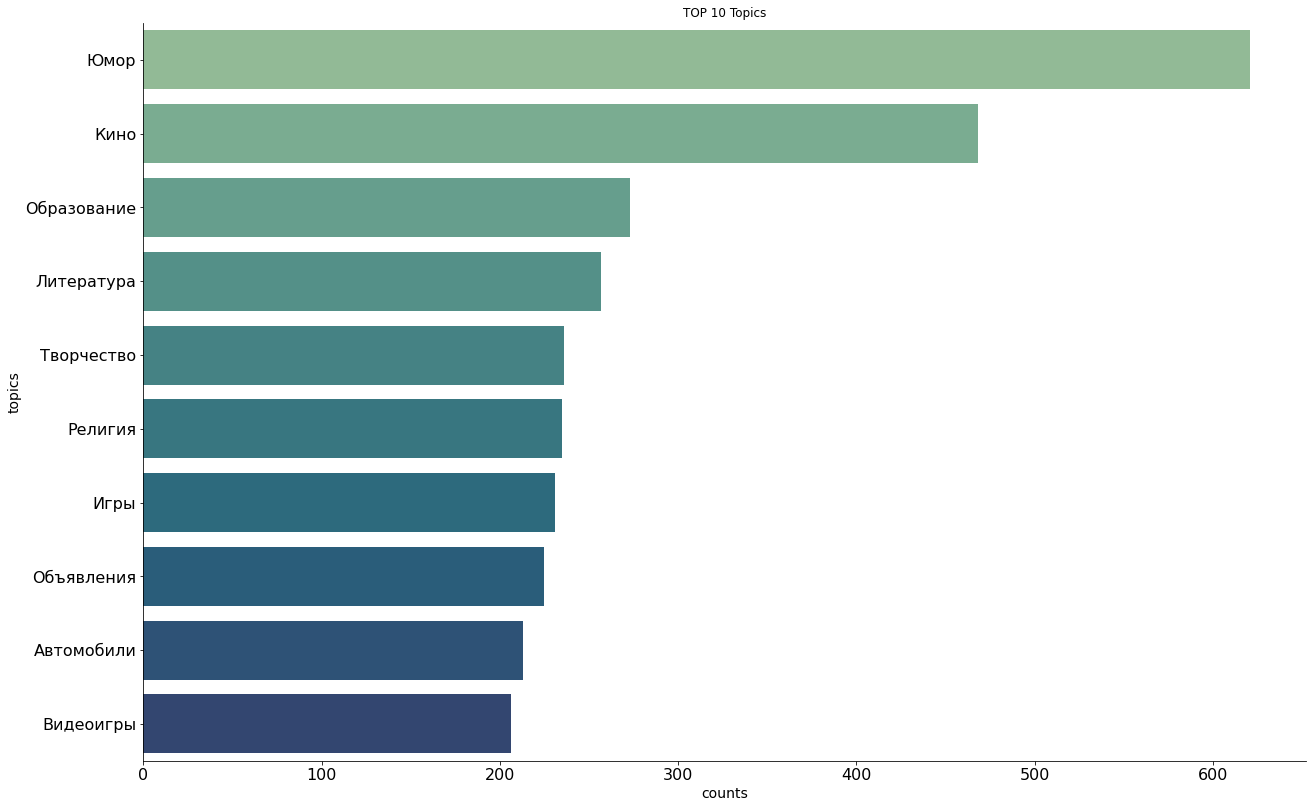

In [51]:
top_topics(topics)

In [61]:
def top_groups(groups, count=15):
    """
    Топ сообществ
    """
    
    # кол-во юзеров каждго сообщества
    fdist = FreqDist(groups)
    fdist = fdist.most_common()
    top_groups = pd.DataFrame(fdist, columns=['groups', 'counts'])[:count]

    # названия сообществ
    names = []
    for i in top_groups.groups:
        name = vk_request('groups.getById', f'group_id={i}')[0]['name']
        names.append(name)
        
    df = pd.DataFrame(names, columns=['top_groups'])
    return df

In [62]:
top_groups(groups_sample)

,top_groups
0,Taker | Тейкер
1,БЕРКАТ | Ингушетия ✥
2,Леонардо Дайвинчик
3,Taker | Тейкер
4,ИЗ РУК В РУКИ | ВАЙНАХТОРГ
5,Cabura | Кабура
6,UP-X
7,Целуй и Знакомься
8,Я ♡ КИНО
9,ВКонтакте


In [58]:
def word_cloud(topics):
    """
    Смотрим на облако частотных слов
    """
    
    # загружаем изображение
    youtube_mask = np.array(Image.open(r'C:\Users\pc\Downloads\vk.png'))
    youtube_mask = np.where(youtube_mask > 3, 255, youtube_mask)

    # Создаем текст для облака частотных слов
    text_wordcloud = ' '.join(map(str, topics[:50]))
    wordcloud = WordCloud(max_font_size=100,
                              mask=youtube_mask,
                              background_color='white',
                              contour_color='blue',
                              contour_width=8,
                              colormap='Blues').generate(text_wordcloud)

    # Визуализация
    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud)
    plt.title('Wordcloud of topics from VK', fontsize=10)
    plt.axis("off")
    
    return plt.show()

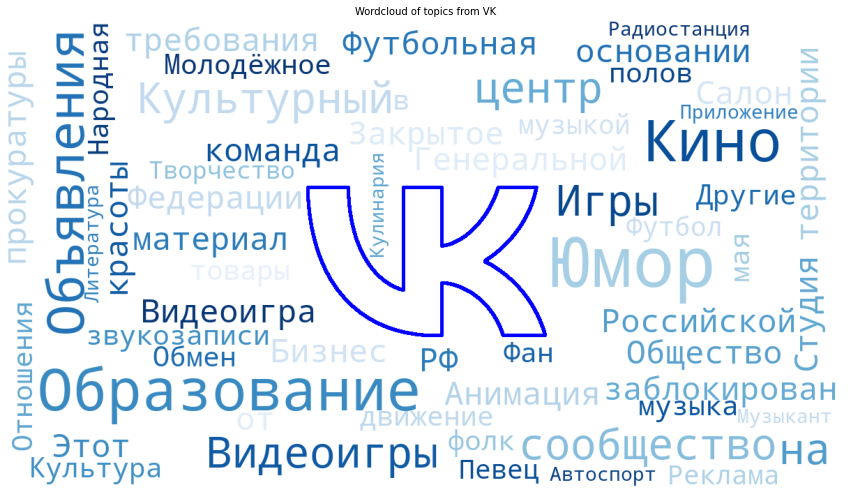

In [28]:
word_cloud(topics)